# Дипломная работа "Прогнозирование цены квартиры по ее параметрам"

## Загрузка и изучение данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d.axes3d import Axes3D
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [146]:
train_df = pd.read_csv('train.csv', index_col='Id')
test_df = pd.read_csv('test.csv', index_col='Id')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,nan,0,11,B,"184,966.93"
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,"300,009.45"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,"220,925.91"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"175,616.23"
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,"2,078.00",2,4,B,"150,226.53"


## Анализ данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [7]:
train_df.shape

(10000, 19)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  object 
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   object 
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     3959 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   object 
 10  Ecology_3      5000 non-null   object 
 11  Social_1       5000 non-null   int64  
 12  Social_2       5000 non-null   int64  
 13  Social_3       5000 non-null   int64  
 14  Healthcare_1   2623 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   object 
dtypes: fl

In [10]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


In [11]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,"5,000.00","5,000.00","3,959.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","5,000.00","2,623.00","5,000.00","5,000.00"
mean,1.91,56.45,36.16,5.98,8.63,12.60,"1,984.39",0.12,24.93,"5,406.90",8.26,"1,146.66",1.32,4.24
std,0.84,19.09,17.83,9.95,5.48,6.79,18.57,0.12,17.53,"4,026.61",23.86,"1,044.74",1.48,4.78
min,0.00,1.38,0.33,0.00,1.00,0.00,"1,908.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00
25%,1.00,41.91,23.09,1.00,4.00,9.00,"1,973.00",0.02,6.00,"1,564.00",0.00,325.00,0.00,1.00
50%,2.00,52.92,32.93,6.00,7.00,12.00,"1,977.00",0.07,25.00,"5,285.00",2.00,900.00,1.00,3.00
75%,2.00,66.29,45.17,9.00,12.00,17.00,"2,000.00",0.20,36.00,"7,287.00",5.00,"1,548.00",2.00,6.00
max,17.00,223.45,303.07,620.00,78.00,99.00,"2,020.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00


In [12]:
train_df.describe(include='object')

,DistrictId,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000,10000
unique,205,2,2,2
top,27,B,B,B
freq,851,9903,9725,9175


In [13]:
test_df.describe(include='object')

,DistrictId,Ecology_2,Ecology_3,Shops_2
count,5000,5000,5000,5000
unique,201,2,2,2
top,27,B,B,B
freq,391,4952,4851,4588


### Целевая переменная

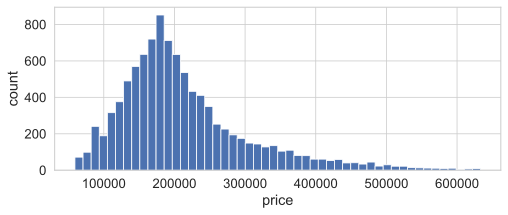

In [147]:
plt.figure(figsize = (8, 3))

train_df['Price'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('price')
plt.show()

### Изучение характеристик

In [15]:
train_df['Rooms'].value_counts()

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
19.00       1
6.00        1
Name: Rooms, dtype: int64

In [16]:
test_df['Rooms'].value_counts()

2.00     2030
1.00     1769
3.00     1099
4.00       90
5.00        7
0.00        2
6.00        2
17.00       1
Name: Rooms, dtype: int64

In [17]:
train_df['KitchenSquare'].value_counts().sort_values()

54.00       1
72.00       1
96.00       1
66.00       1
48.00       1
         ... 
6.00     1038
10.00    1075
5.00     1169
8.00     1306
1.00     2460
Name: KitchenSquare, Length: 58, dtype: int64

In [18]:
test_df['KitchenSquare'].value_counts().sort_values()

41.00        1
112.00       1
61.00        1
33.00        1
34.00        1
620.00       1
97.00        1
57.00        1
62.00        1
30.00        1
40.00        1
44.00        1
60.00        1
22.00        1
65.00        1
24.00        1
20.00        2
19.00        2
18.00        3
42.00        3
2.00         4
17.00        5
3.00        11
16.00       13
15.00       17
14.00       20
4.00        21
13.00       33
11.00      107
12.00      132
7.00       297
0.00       335
9.00       417
10.00      558
6.00       595
8.00       606
5.00       612
1.00      1191
Name: KitchenSquare, dtype: int64

In [19]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [20]:
(test_df['Floor'] > test_df['HouseFloor']).sum()

884

In [21]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [22]:
test_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
       78], dtype=int64)

In [23]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [24]:
test_df['HouseFloor'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
       48., 99.])

In [25]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [26]:
test_df['HouseYear'].sort_values().unique()

array([1908, 1909, 1910, 1911, 1912, 1914, 1917, 1918, 1920, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1937, 1938, 1939,
       1940, 1941, 1943, 1948, 1949, 1950, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [5]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
205      1
174      1
209      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [29]:
train_df.loc[(train_df['Rooms'] > 5)|(train_df['Rooms'] == 0)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5927,57,10.00,59.06,36.22,10.00,22,22.00,2002,0.09,B,B,74,19083,2,nan,5,15,B,"317,265.32"
12638,27,0.00,138.43,136.22,0.00,4,3.00,2016,0.08,B,B,11,3097,0,nan,0,0,B,"268,394.74"
8491,1,19.00,42.01,21.78,7.00,17,17.00,2014,0.01,B,B,1,264,0,nan,0,1,B,"78,364.62"
7917,27,0.00,212.93,211.23,0.00,2,3.00,2008,0.21,B,B,9,1892,0,nan,0,1,B,"302,211.26"
14003,99,6.00,59.41,38.70,6.00,7,9.00,1969,0.03,B,B,66,10573,1,"1,322.00",3,8,B,"229,661.96"
7317,27,0.00,41.79,nan,0.00,13,0.00,1977,0.21,B,B,9,1892,0,nan,0,1,B,"98,129.98"
770,28,0.00,49.48,nan,0.00,16,0.00,2015,0.12,B,B,30,6207,1,"1,183.00",1,0,B,"217,009.34"
456,6,0.00,81.49,nan,0.00,4,0.00,1977,0.24,B,B,5,1564,0,540.00,0,0,B,"212,864.80"
3224,27,0.00,2.38,0.87,0.00,1,0.00,1977,0.02,B,B,2,469,0,nan,0,0,B,"126,596.94"


In [30]:
test_df.loc[(test_df['Rooms'] > 5)|(test_df['Rooms'] == 0)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10793,23,6.00,110.75,nan,0.00,2,2.00,2015,0.01,B,B,2,475,0,nan,0,0,B
3343,58,0.00,116.82,113.69,0.00,3,3.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B
10729,27,0.00,76.35,42.82,12.00,14,0.00,1977,0.02,B,B,2,469,0,nan,0,0,B
4058,27,6.00,223.45,104.11,16.00,2,2.00,2017,0.04,B,B,53,14892,4,nan,1,4,B
1435,111,17.00,52.87,32.53,8.00,15,17.00,1987,0.09,B,B,23,4635,5,"3,300.00",2,4,B


In [149]:
feature_num_names = train_df.drop('Price', axis=1).select_dtypes(include=['float64', 'int64']).\
        columns.tolist()
feature_num_names

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

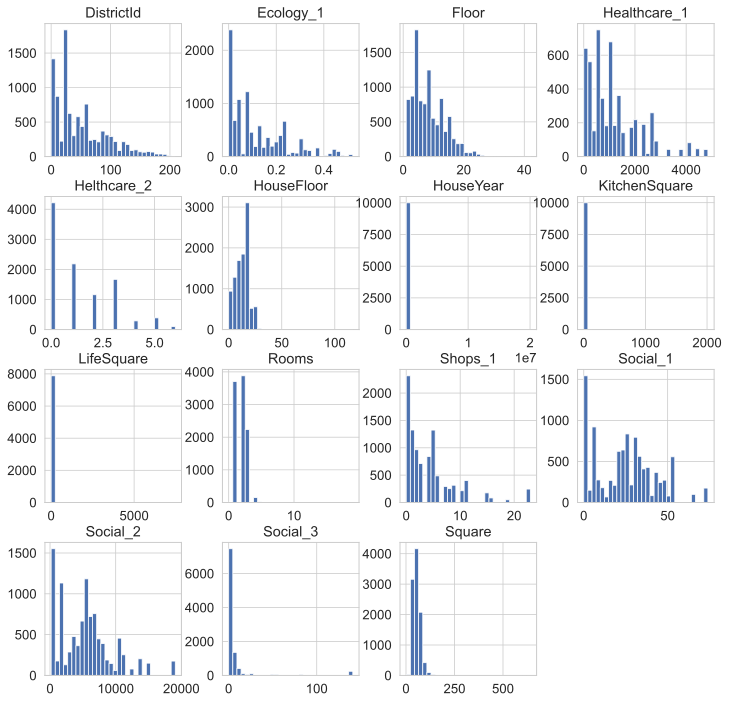

In [150]:
train_df[feature_num_names].hist(figsize=(12, 12), bins=30, grid=True);

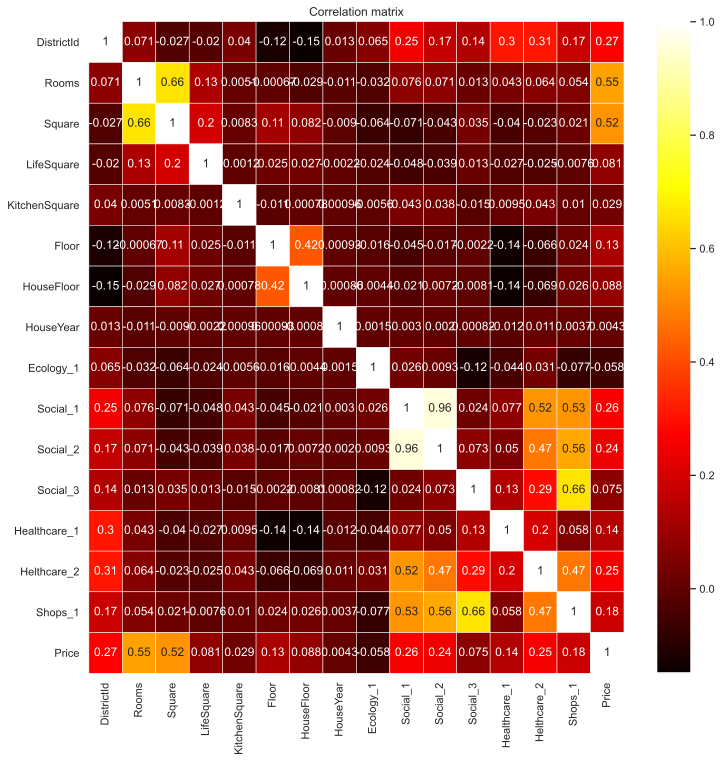

In [151]:
plt.figure(figsize = (12,12))

sns.set(font_scale=1)
sns.heatmap(train_df[feature_num_names + ['Price']].corr(), 
            annot=True, linewidths=.5, cmap='hot')

plt.title('Correlation matrix');

In [60]:
train_df_new['Helthcare_2'].value_counts().sort_values()

6      99
4     288
5     388
2    1158
3    1670
1    2183
0    4214
Name: Helthcare_2, dtype: int64

In [61]:
test_df_new['Helthcare_2'].value_counts().sort_values()

6      39
4     158
5     186
2     570
3     855
1    1096
0    2096
Name: Helthcare_2, dtype: int64

## Обработка выбросов

### LifeSquare

In [10]:
train_df.loc[(train_df['LifeSquare'] > 150), ['Square', 'LifeSquare']].sort_values(['LifeSquare'], ascending=False)

,Square,LifeSquare
Id,,
16550,81.69,"7,480.59"
11602,641.07,638.16
15886,78.06,461.46
2307,409.43,410.64
14990,48.45,263.54
5548,275.65,233.95
7917,212.93,211.23
16568,200.33,201.63
11055,174.65,174.84


In [11]:
test_df.loc[(test_df['LifeSquare'] > 150), ['Square', 'LifeSquare']]

,Square,LifeSquare
Id,,
11533,48.71,303.07
16053,168.73,169.90


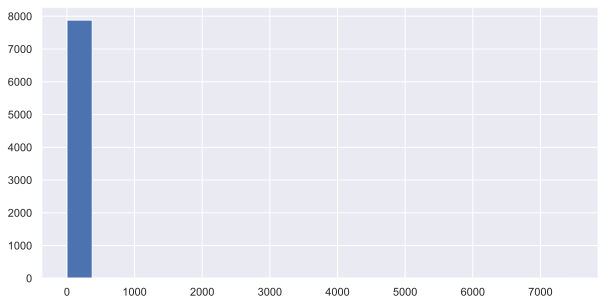

In [152]:
train_df['LifeSquare'].hist(figsize=(10, 5), bins=20, grid=True);

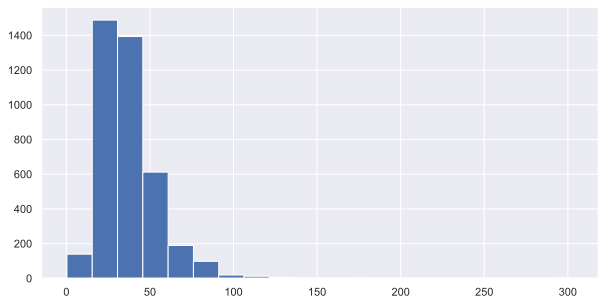

In [153]:
test_df['LifeSquare'].hist(figsize=(10, 5), bins=20, grid=True);

**Вывод: выявлено 1 значение 7480, которе явно похоже на ошибку. Производем замену на Null для последующего заполнения с помощью IterativeImputer**

In [154]:
train_df.loc[(train_df['LifeSquare'] > 1000), 'LifeSquare'] = None
test_df.loc[(test_df['LifeSquare'] > 1000), 'LifeSquare'] = None

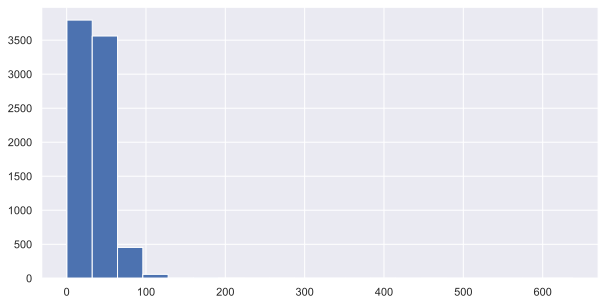

In [155]:
train_df['LifeSquare'].hist(figsize=(10, 5), bins=20, grid=True);

### Square

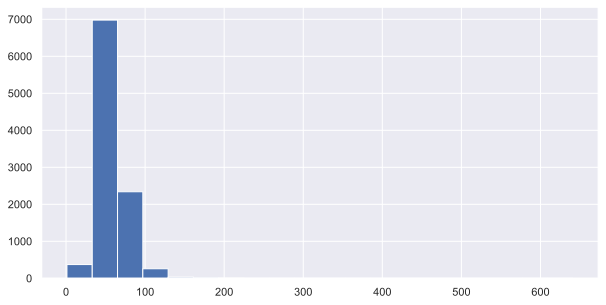

In [156]:
train_df['Square'].hist(figsize=(10, 5), bins=20, grid=True);

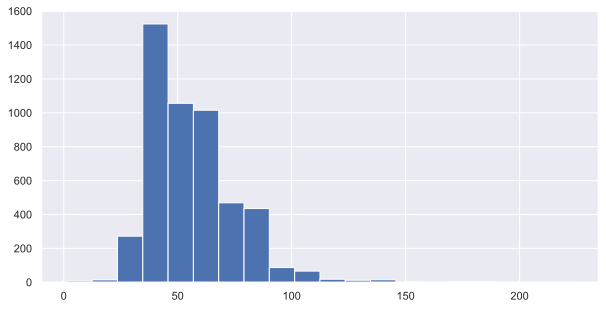

In [157]:
test_df['Square'].hist(figsize=(10, 5), bins=20, grid=True);

In [158]:
train_df.loc[(train_df['Square'] > 150), ['Square', 'LifeSquare', 'Rooms', 'Price']].sort_values('Square')

,Square,LifeSquare,Rooms,Price
Id,,,,
14556,151.15,98.19,4.00,"284,884.96"
3914,155.93,76.83,4.00,"559,886.97"
14181,156.64,153.69,3.00,"502,523.57"
16204,160.65,nan,1.00,"217,875.00"
2603,162.59,164.53,3.00,"207,407.35"
15362,163.29,161.16,1.00,"228,572.52"
5621,163.50,161.50,3.00,"207,007.96"
4991,167.77,nan,3.00,"211,180.79"
6674,168.09,125.49,1.00,"367,353.57"


In [19]:
test_df.loc[(test_df['Square'] > 150), ['Square', 'LifeSquare', 'Rooms']].sort_values('Square')

,Square,LifeSquare,Rooms
Id,,,
12316,157.98,101.04,5.00
14498,163.33,nan,1.00
16053,168.73,169.90,4.00
3357,170.48,75.97,3.00
13589,173.97,76.29,3.00
7769,189.68,114.71,4.00
1397,221.14,118.06,3.00
4058,223.45,104.11,6.00


**Вывод: по площади явных отклонений от нормальных значений не выявлено**

### KitchenSquare

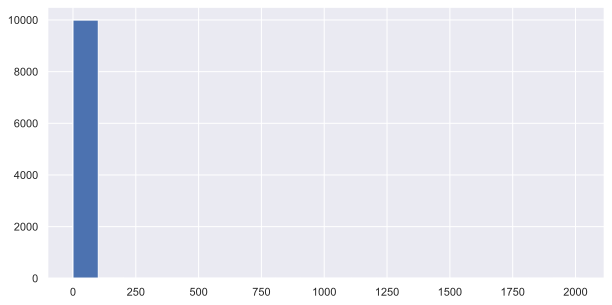

In [159]:
train_df['KitchenSquare'].hist(figsize=(10, 5), bins=20, grid=True);

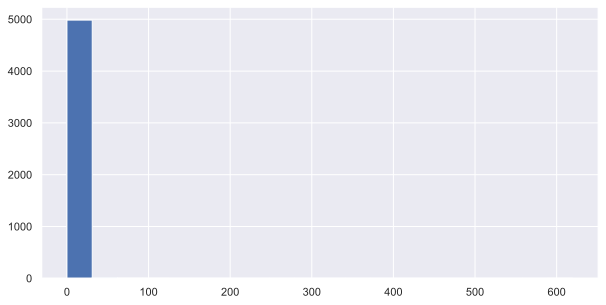

In [160]:
test_df['KitchenSquare'].hist(figsize=(10, 5), bins=20, grid=True);

In [161]:
train_df.loc[(train_df['KitchenSquare'] > 100), ['KitchenSquare', 'Square']]\
.sort_values('KitchenSquare')

,KitchenSquare,Square
Id,,
7441,112.00,114.73
12552,112.00,116.41
2737,123.00,123.43
14679,"1,970.00",32.28
14656,"2,014.00",47.10


In [162]:
test_df.loc[(test_df['KitchenSquare'] > 100), ['KitchenSquare', 'Square']]\
.sort_values('KitchenSquare')

,KitchenSquare,Square
Id,,
3341,112.00,112.11
14594,620.00,42.80


In [163]:
train_df.loc[(train_df['KitchenSquare'] > train_df['Square']), ['KitchenSquare', 'Square']]\
.sort_values('KitchenSquare')

,KitchenSquare,Square
Id,,
13703,73.00,38.07
6569,84.00,38.22
14679,"1,970.00",32.28
14656,"2,014.00",47.10


In [164]:
test_df.loc[(test_df['KitchenSquare'] > test_df['Square']), ['KitchenSquare', 'Square']]\
.sort_values('KitchenSquare')

,KitchenSquare,Square
Id,,
10662,33.00,25.96
3194,44.00,43.93
12640,97.00,54.63
14594,620.00,42.80


**Вывод: есть явные ошибки в строках, где площадь кухни больше 500, а также есть строки, где площадь кухни больше общей площади, что также будем считать ошибкой. Заменим выбросы на пустые значения для последующей обработки**

In [165]:
train_df.loc[(train_df['KitchenSquare'] > 500) | (train_df['KitchenSquare'] > train_df['Square']), 'KitchenSquare']\
= None

test_df.loc[(test_df['KitchenSquare'] > 500) | (test_df['KitchenSquare'] > test_df['Square']), 'KitchenSquare']\
= None

### Rooms

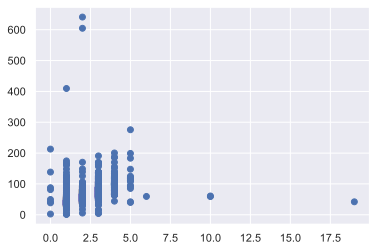

In [166]:
plt.scatter(train_df['Rooms'], train_df['Square']);

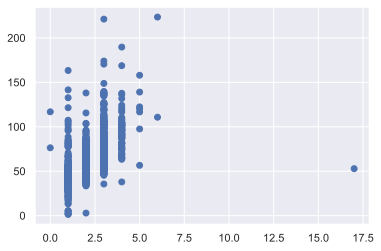

In [167]:
plt.scatter(test_df['Rooms'], test_df['Square']);

In [29]:
train_df['Rooms'].mode()[0]

2.0

In [30]:
test_df['Rooms'].mode()[0]

2.0

In [31]:
train_df.loc[(train_df['Rooms'] > 5), ['Rooms', 'Square', 'KitchenSquare', 'LifeSquare']]

,Rooms,Square,KitchenSquare,LifeSquare
Id,,,,
5927,10.00,59.06,10.00,36.22
8491,19.00,42.01,7.00,21.78
14003,6.00,59.41,6.00,38.70
14865,10.00,60.87,10.00,38.42


In [64]:
test_df.loc[(test_df['Rooms'] > 5), ['Rooms', 'Square', 'KitchenSquare', 'LifeSquare']]

,Rooms,Square,KitchenSquare,LifeSquare
Id,,,,
10793,6.00,110.75,0.00,nan
4058,6.00,223.45,16.00,104.11
1435,17.00,52.87,8.00,32.53


**Вывод: экземпляры с ошибками можно отсеять по условию 'Rooms' > 6**

In [168]:
train_df.loc[(train_df['Rooms'] > 6), 'Rooms'] = None
test_df.loc[(test_df['Rooms'] > 6), 'Rooms'] = None

### HouseYear

In [33]:
train_df['HouseYear'].sort_values(ascending=False)

Id
10814    20052011
11607        4968
6731         2020
8892         2020
14318        2020
           ...   
7920         1916
6751         1914
2085         1912
14556        1912
13288        1910
Name: HouseYear, Length: 10000, dtype: int64

In [34]:
test_df['HouseYear'].sort_values(ascending=False)

Id
2359     2020
8311     2020
8560     2020
9398     2020
4696     2020
         ... 
16217    1912
3726     1911
9076     1910
5480     1909
12316    1908
Name: HouseYear, Length: 5000, dtype: int64

**Вывод: есть явные ошибки в указании года, которые можно исправить на корректные значения**

In [169]:
train_df.loc[10814, 'HouseYear'] = 2011
train_df.loc[11607, 'HouseYear'] = 1968

## Замена категориальных признаков на бинарные

In [170]:
feature_bin_names = train_df.select_dtypes(include='object').columns.tolist()
train_df[feature_bin_names] = train_df[feature_bin_names].replace({'A':0, 'B':1})
test_df[feature_bin_names] = test_df[feature_bin_names].replace({'A':0, 'B':1})

## Заполнения пропусков с помощью IterativeImputer

In [171]:
train_df.isna().sum()

DistrictId          0
Rooms               3
Square              0
LifeSquare       2114
KitchenSquare       4
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [172]:
test_df.isna().sum()

DistrictId          0
Rooms               1
Square              0
LifeSquare       1041
KitchenSquare       4
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [173]:
feature_names = train_df.drop(['DistrictId', 'Price'], axis=1).columns
X_train = train_df[feature_names]
X_test = test_df[feature_names]

In [174]:
imputer = IterativeImputer(random_state=42, imputation_order='random', estimator=DecisionTreeRegressor(random_state=42))
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.fit_transform(X_test)

In [175]:
train_df_new = pd.DataFrame(X_train_imp, index=train_df.index, columns=feature_names)
train_df_new.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,
14038,2.00,47.98,29.44,6.00,7.00,9.00,"1,969.00",0.09,1.00,1.00,33.00,"7,976.00",5.00,900.00,0.00,11.00,1.00
15053,3.00,65.68,40.05,8.00,7.00,9.00,"1,978.00",0.00,1.00,1.00,46.00,"10,309.00",1.00,240.00,1.00,16.00,1.00
4765,2.00,44.95,29.20,0.00,8.00,12.00,"1,968.00",0.05,1.00,1.00,34.00,"7,759.00",0.00,229.00,1.00,3.00,1.00
5809,2.00,53.35,52.73,9.00,8.00,17.00,"1,977.00",0.44,1.00,1.00,23.00,"5,735.00",3.00,"1,084.00",0.00,5.00,1.00
10783,1.00,39.65,23.78,7.00,11.00,12.00,"1,976.00",0.01,1.00,1.00,35.00,"5,776.00",1.00,"2,078.00",2.00,4.00,1.00


In [176]:
test_df_new = pd.DataFrame(X_test_imp, index=test_df.index, columns=feature_names)
test_df_new.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,
725,2.00,49.88,33.43,6.00,6.00,14.00,"1,972.00",0.31,1.00,1.00,11.00,"2,748.00",1.00,35.00,0.00,0.00,1.00
15856,2.00,69.26,5.45,1.00,6.00,1.00,"1,977.00",0.08,1.00,1.00,6.00,"1,437.00",3.00,"1,547.00",0.00,2.00,1.00
5480,1.00,13.60,15.95,12.00,2.00,5.00,"1,909.00",0.00,1.00,1.00,30.00,"7,538.00",87.00,"4,702.00",5.00,5.00,1.00
15664,2.00,73.05,51.94,9.00,22.00,22.00,"2,007.00",0.10,1.00,1.00,23.00,"4,583.00",3.00,"3,300.00",3.00,3.00,1.00
14275,1.00,47.53,43.39,1.00,17.00,17.00,"2,017.00",0.07,1.00,1.00,2.00,629.00,1.00,0.00,0.00,0.00,0.00


**Возвращаем колонки 'DistrictId', 'Price' обратно**

In [177]:
train_df_new = train_df_new.join(train_df[['DistrictId', 'Price']])

In [178]:
test_df_new = test_df_new.join(test_df[['DistrictId']])

## Сохрание промежуточных результатов анализа и трансформации train и test

In [46]:
train_df_new.to_csv('train_df_new.csv', encoding='utf-8')
test_df_new.to_csv('test_df_new.csv', encoding='utf-8')

## Построение новых признаков

In [183]:
train_df_new = pd.read_csv('train_df_new.csv', index_col='Id')
test_df_new = pd.read_csv('test_df_new.csv', index_col='Id')

### Средняя цена 1 м2 в зависимости от района

In [184]:
train_df_new['Price1m'] = train_df_new['Price'] / train_df_new['Square']

In [185]:
price_1m_by_district = train_df_new.groupby(['DistrictId'], as_index=False)\
                        .agg({'Price1m':'median'})\
                        .rename(columns={'Price1m':'Price1mByDistrict'})

In [186]:
train_df_new = train_df_new.merge(price_1m_by_district, on=['DistrictId'], how='left').set_index(train_df_new.index)
test_df_new = test_df_new.merge(price_1m_by_district, on=['DistrictId'], how='left').set_index(test_df_new.index)

### Признак, что квартира расположена на последнем или первом этажах

In [187]:
train_df_new.loc[(train_df_new['Floor'] == 1), 'IsFirstFloor'] = 1
test_df_new.loc[(test_df_new['Floor'] == 1), 'IsFirstFloor'] = 1

train_df_new.loc[(train_df_new['Floor'] != 1), 'IsFirstFloor'] = 0
test_df_new.loc[(test_df_new['Floor'] != 1), 'IsFirstFloor'] = 0

train_df_new.loc[(train_df_new['Floor'] >= train_df_new['HouseFloor']), 'IsLastFloor'] = 1
test_df_new.loc[(test_df_new['Floor'] >= test_df_new['HouseFloor']), 'IsLastFloor'] = 1

train_df_new.loc[(train_df_new['Floor'] < train_df_new['HouseFloor']), 'IsLastFloor'] = 0
test_df_new.loc[(test_df_new['Floor'] < test_df_new['HouseFloor']), 'IsLastFloor'] = 0

### Квартиры, у которых жилая площадь больше, чем общая

In [188]:
train_df_new.loc[(train_df_new['LifeSquare'] > train_df_new['Square']), 'SquareOutliers'] = 1

test_df_new.loc[(test_df_new['LifeSquare'] > test_df_new['Square']), 'SquareOutliers'] = 1

train_df_new.loc[(train_df_new['LifeSquare'] <= train_df_new['Square']), 'SquareOutliers'] = 0

test_df_new.loc[(test_df_new['LifeSquare'] <= test_df_new['Square']), 'SquareOutliers'] = 0

### Объединение редких районов в район 999 и добавление признака с количеством квартир по районам

In [189]:
district_size = train_df_new['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

**Заменим районы с количеством квартир <=10 на район с кодом 999**

In [190]:
districts_popular = district_size.loc[district_size['DistrictSize'] >= 10, 'DistrictId'].tolist()

district_size.loc[~district_size['DistrictId'].isin(districts_popular), 'DistrictId'] = '999'

In [191]:
district_size = district_size.groupby('DistrictId')['DistrictSize'].agg(
                            DistrictSize='median')

district_size.reset_index(level='DistrictId', inplace=True)

In [192]:
train_df_new.loc[~train_df_new['DistrictId'].isin(districts_popular), 'DistrictId'] = '999'
test_df_new.loc[~test_df_new['DistrictId'].isin(districts_popular), 'DistrictId'] = '999'

In [193]:
train_df_new = train_df_new.merge(district_size, on='DistrictId', how='left').set_index(train_df_new.index)
test_df_new = test_df_new.merge(district_size, on='DistrictId', how='left').set_index(test_df_new.index)

In [194]:
train_df_new['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
999    295
      ... 
156     10
155     10
187     10
154     10
72      10
Name: DistrictId, Length: 145, dtype: int64

In [195]:
test_df_new['DistrictId'].value_counts()

27     391
1      344
23     264
6      257
999    164
      ... 
163      3
110      3
36       2
154      2
150      1
Name: DistrictId, Length: 145, dtype: int64

### Средняя цена 1 комнаты в зависимости от района

In [196]:
train_df_new['PriceOneRoom'] = train_df_new['Price'] / train_df_new['Rooms']

price_by_district = train_df_new.groupby(['DistrictId'], as_index=False)\
                        .agg({'PriceOneRoom':'median'})\
                        .rename(columns={'PriceOneRoom':'PriceOneRoomByDistrict'})

train_df_new = train_df_new.merge(price_by_district, on=['DistrictId'], how='left').set_index(train_df_new.index)

test_df_new = test_df_new.merge(price_by_district, on=['DistrictId'], how='left').set_index(test_df_new.index)

### Категории в зависимости от этажа расположения квартиры

In [197]:
floor_boarders = [0, 1, 5, 12, 17, 117]
train_df_new.insert(5, "FloorGroup", pd.cut(train_df_new['Floor'], floor_boarders, right=True, labels=[0, 1, 2, 3, 4]), True)
test_df_new.insert(5, "FloorGroup", pd.cut(test_df_new['Floor'], floor_boarders, right=True, labels=[0, 1, 2, 3, 4]), True)

### Категории в зависимости от площади

In [198]:
square_boarders = [0, 19, 38, 56, 74, 93, 111, 1000]
train_df_new.insert(5, "SquareGroup", pd.cut(train_df_new['Square'], square_boarders, right=False, labels=[0, 1, 2, 3, 4, 5, 6]), True)
test_df_new.insert(5, "SquareGroup", pd.cut(test_df_new['Square'], square_boarders, right=False, labels=[0, 1, 2, 3, 4, 5, 6]), True)

In [199]:
train_df_new['SquareGroup'].value_counts()

2    4471
3    2557
4    1399
1    1181
5     241
6     131
0      20
Name: SquareGroup, dtype: int64

In [200]:
test_df_new['SquareGroup'].value_counts()

2    2179
3    1278
4     746
1     600
5     127
6      57
0      13
Name: SquareGroup, dtype: int64

### Средняя цена 1 м2 в зависимости от категории по площади квартиры

In [201]:
price_by_square_group = train_df_new.groupby(['SquareGroup'], as_index=False)\
                        .agg({'Price1m':'median'})\
                        .rename(columns={'Price1m':'Price1mBySquareGroup'})

train_df_new = train_df_new.merge(price_by_square_group, on=['SquareGroup'], how='left').set_index(train_df_new.index)

test_df_new = test_df_new.merge(price_by_square_group, on=['SquareGroup'], how='left').set_index(test_df_new.index)

### Средняя цена 1 м2 в зависимости от категории по этажности расположения

In [202]:
price_by_floor_group = train_df_new.groupby(['FloorGroup'], as_index=False)\
                        .agg({'Price1m':'median'})\
                        .rename(columns={'Price1m':'Price1mByFloorGroup'})

train_df_new = train_df_new.merge(price_by_floor_group, on=['FloorGroup'], how='left').set_index(train_df_new.index)

test_df_new = test_df_new.merge(price_by_floor_group, on=['FloorGroup'], how='left').set_index(test_df_new.index)

### Признак, что квартира размещается выше, чем этажность дома

In [203]:
train_df_new.loc[(train_df_new['Floor'] > train_df_new['HouseFloor']), 'FloorOutliers'] = 1
test_df_new.loc[(test_df_new['Floor'] > test_df_new['HouseFloor']), 'FloorOutliers'] = 1

train_df_new.loc[(train_df_new['Floor'] <= train_df_new['HouseFloor']), 'FloorOutliers'] = 0
test_df_new.loc[(test_df_new['Floor'] <= test_df_new['HouseFloor']), 'FloorOutliers'] = 0

### HouseAgeGroup

In [204]:
age_boarders = [1900, 1970, 1990, 2010, 2021]
train_df_new.insert(5, "HouseAgeGroup", pd.cut(train_df_new['HouseYear'], age_boarders, right=True, labels=[0, 1, 2, 3]), True)
test_df_new.insert(5, "HouseAgeGroup", pd.cut(test_df_new['HouseYear'], age_boarders, right=True, labels=[0, 1, 2, 3]), True)

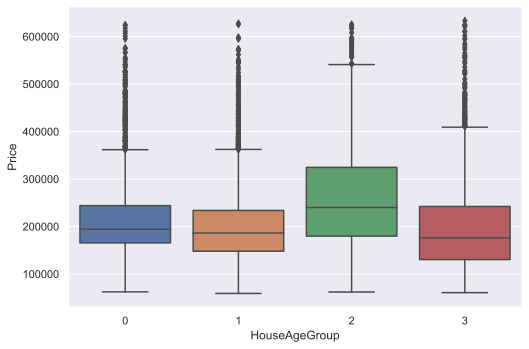

In [205]:
sns.catplot("HouseAgeGroup", "Price", kind="box", data=train_df_new, aspect=3/2);

### Средняя цена 1 м2 в зависимости от категории по возрасту дома

In [206]:
price_by_age_group = train_df_new.groupby(['HouseAgeGroup'], as_index=False)\
                        .agg({'Price1m':'median'})\
                        .rename(columns={'Price1m':'Price1mByAgeGroup'})

train_df_new = train_df_new.merge(price_by_age_group, on=['HouseAgeGroup'], how='left').set_index(train_df_new.index)

test_df_new = test_df_new.merge(price_by_age_group, on=['HouseAgeGroup'], how='left').set_index(test_df_new.index)

### Приведение типов и удаление лишних признаков

In [207]:
train_df_new.drop(['Price1m', 'PriceOneRoom', 'DistrictId'], axis=1, inplace=True)
test_df_new.drop(['DistrictId'], axis=1, inplace=True)

In [208]:
train_df_new.isna().sum()[train_df_new.isna().sum() != 0]

Series([], dtype: int64)

In [209]:
test_df_new.isna().sum()[test_df_new.isna().sum() != 0]

Price1mByDistrict    8
dtype: int64

In [210]:
test_df_new['Price1mByDistrict'].fillna(train_df_new['Price1mByDistrict'].median(), inplace=True)

In [211]:
test_df_new.isna().sum()[test_df_new.isna().sum() != 0]

Series([], dtype: int64)

In [212]:
train_df_new['HouseAgeGroup'] = train_df_new['HouseAgeGroup'].astype('int64')
test_df_new['HouseAgeGroup'] = test_df_new['HouseAgeGroup'].astype('int64')

train_df_new['SquareGroup'] = train_df_new['SquareGroup'].astype('int64')
test_df_new['SquareGroup'] = test_df_new['SquareGroup'].astype('int64')

train_df_new['FloorGroup'] = train_df_new['FloorGroup'].astype('int64')
test_df_new['FloorGroup'] = test_df_new['FloorGroup'].astype('int64')

train_df_new['IsFirstFloor'] = train_df_new['IsFirstFloor'].astype('int64')
test_df_new['IsFirstFloor'] = test_df_new['IsFirstFloor'].astype('int64')

train_df_new['IsLastFloor'] = train_df_new['IsLastFloor'].astype('int64')
test_df_new['IsLastFloor'] = test_df_new['IsLastFloor'].astype('int64')

train_df_new['FloorOutliers'] = train_df_new['FloorOutliers'].astype('int64')
test_df_new['FloorOutliers'] = test_df_new['FloorOutliers'].astype('int64')

train_df_new['FloorOutliers'] = train_df_new['FloorOutliers'].astype('int64')
test_df_new['FloorOutliers'] = test_df_new['FloorOutliers'].astype('int64')

train_df_new['SquareOutliers'] = train_df_new['SquareOutliers'].astype('int64')
test_df_new['SquareOutliers'] = test_df_new['SquareOutliers'].astype('int64')

train_df_new['HouseYear'] = train_df_new['HouseYear'].astype('int64')
test_df_new['HouseYear'] = test_df_new['HouseYear'].astype('int64')

train_df_new['Ecology_2'] = train_df_new['Ecology_2'].astype('int64')
test_df_new['Ecology_2'] = test_df_new['Ecology_2'].astype('int64')

train_df_new['Ecology_3'] = train_df_new['Ecology_3'].astype('int64')
test_df_new['Ecology_3'] = test_df_new['Ecology_3'].astype('int64')

train_df_new['Helthcare_2'] = train_df_new['Helthcare_2'].astype('int64')
test_df_new['Helthcare_2'] = test_df_new['Helthcare_2'].astype('int64')

train_df_new['Shops_2'] = train_df_new['Shops_2'].astype('int64')
test_df_new['Shops_2'] = test_df_new['Shops_2'].astype('int64')

train_df_new['Rooms'] = train_df_new['Rooms'].astype('float64')
test_df_new['Rooms'] = test_df_new['Rooms'].astype('float64')

train_df_new['Floor'] = train_df_new['Floor'].astype('float64')
test_df_new['Floor'] = test_df_new['Floor'].astype('float64')

train_df_new['HouseFloor'] = train_df_new['HouseFloor'].astype('float64')
test_df_new['HouseFloor'] = test_df_new['HouseFloor'].astype('float64')

train_df_new['Social_3'] = train_df_new['Social_3'].astype('float64')
test_df_new['Social_3'] = test_df_new['Social_3'].astype('float64')

train_df_new['DistrictSize'] = train_df_new['DistrictSize'].astype('float64')
test_df_new['DistrictSize'] = test_df_new['DistrictSize'].astype('float64')

## Сохрание промежуточных результатов анализа и трансформации train и test

In [87]:
train_df_new.to_csv('train_df_new_2.csv', encoding='utf-8')
test_df_new.to_csv('test_df_new_2.csv', encoding='utf-8')

## Стадартизация

In [11]:
train_df_new = pd.read_csv('train_df_new_2.csv', index_col='Id')
test_df_new = pd.read_csv('test_df_new_2.csv', index_col='Id')

In [213]:
train_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Rooms                   10000 non-null  float64
 1   Square                  10000 non-null  float64
 2   LifeSquare              10000 non-null  float64
 3   KitchenSquare           10000 non-null  float64
 4   Floor                   10000 non-null  float64
 5   HouseAgeGroup           10000 non-null  int64  
 6   SquareGroup             10000 non-null  int64  
 7   FloorGroup              10000 non-null  int64  
 8   HouseFloor              10000 non-null  float64
 9   HouseYear               10000 non-null  int64  
 10  Ecology_1               10000 non-null  float64
 11  Ecology_2               10000 non-null  int64  
 12  Ecology_3               10000 non-null  int64  
 13  Social_1                10000 non-null  float64
 14  Social_2                10000 non-n

In [214]:
feature_num_names = train_df_new.select_dtypes(include='float64').columns.tolist()

In [215]:
train_df_new[feature_num_names].head(10)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,Price,Price1mByDistrict,DistrictSize,PriceOneRoomByDistrict,Price1mBySquareGroup,Price1mByFloorGroup,Price1mByAgeGroup
Id,,,,,,,,,,,,,,,,,,,
14038,2.00,47.98,29.44,6.00,7.00,9.00,0.09,33.00,"7,976.00",5.00,900.00,11.00,"184,966.93","4,358.27",22.00,"121,239.81","3,955.86","3,978.29","4,462.15"
15053,3.00,65.68,40.05,8.00,7.00,9.00,0.00,46.00,"10,309.00",1.00,240.00,16.00,"300,009.45","4,437.30",87.00,"120,688.95","3,505.49","3,978.29","3,524.85"
4765,2.00,44.95,29.20,0.00,8.00,12.00,0.05,34.00,"7,759.00",0.00,229.00,3.00,"220,925.91","4,845.92",174.00,"138,669.20","3,955.86","3,978.29","4,462.15"
5809,2.00,53.35,52.73,9.00,8.00,17.00,0.44,23.00,"5,735.00",3.00,"1,084.00",5.00,"175,616.23","2,949.98",179.00,"105,638.52","3,955.86","3,978.29","3,524.85"
10783,1.00,39.65,23.78,7.00,11.00,12.00,0.01,35.00,"5,776.00",1.00,"2,078.00",4.00,"150,226.53","3,992.03",97.00,"98,852.90","3,955.86","3,978.29","3,524.85"
12915,3.00,80.38,46.68,12.00,5.00,17.00,0.31,35.00,"7,715.00",4.00,990.00,6.00,"215,898.45","4,736.63",67.00,"164,233.42","3,600.60","3,954.61","2,977.99"
14549,2.00,62.25,37.16,7.00,3.00,5.00,0.46,20.00,"4,386.00",14.00,"2,500.00",5.00,"296,021.20","5,445.49",10.00,"142,572.58","3,505.49","3,954.61","4,462.15"
11993,2.00,80.31,84.75,0.00,14.00,0.00,0.08,6.00,"1,437.00",3.00,"1,547.00",2.00,"221,244.16","3,319.32",114.00,"127,646.56","3,600.60","3,652.39","3,524.85"
5172,2.00,64.51,65.85,1.00,9.00,17.00,0.01,1.00,264.00,0.00,200.00,1.00,"229,102.80","3,251.65",652.00,"106,080.90","3,505.49","3,978.29","3,524.85"


In [216]:
feature_num_names.remove('Price')

In [217]:
scaler = StandardScaler()

train_df_scaled = pd.DataFrame(scaler.fit_transform(train_df_new[feature_num_names]), 
                        columns=feature_num_names, 
                        index=train_df_new.index)

test_df_scaled = pd.DataFrame(scaler.transform(test_df_new[feature_num_names]), 
                        columns=feature_num_names, 
                        index=test_df_new.index)

In [218]:
feature_bin_names = train_df_new.select_dtypes(include='int64').columns.tolist()

In [219]:
train_df_new[feature_bin_names].head(10)

,HouseAgeGroup,SquareGroup,FloorGroup,HouseYear,Ecology_2,Ecology_3,Helthcare_2,Shops_2,IsFirstFloor,IsLastFloor,SquareOutliers,FloorOutliers
Id,,,,,,,,,,,,
14038,0,2,2,1969,1,1,0,1,0,0,0,0
15053,1,3,2,1978,1,1,1,1,0,0,0,0
4765,0,2,2,1968,1,1,1,1,0,0,0,0
5809,1,2,2,1977,1,1,0,1,0,0,0,0
10783,1,2,2,1976,1,1,2,1,0,0,0,0
12915,3,4,1,2011,1,1,0,1,0,0,0,0
14549,0,3,1,1960,1,1,1,1,0,0,0,0
11993,1,4,3,1977,1,1,0,1,0,1,1,1
5172,1,3,2,1977,1,1,0,1,0,0,1,0


In [220]:
train_df_scaled[feature_bin_names] = train_df_new[feature_bin_names]
test_df_scaled[feature_bin_names] = test_df_new[feature_bin_names]

In [221]:
train_df_scaled.shape

(10000, 30)

In [222]:
test_df_scaled.shape

(5000, 30)

## Кластеризация

In [223]:
features_for_ecology_cl = ['Ecology_1', 'Ecology_2', 'Ecology_3']

In [224]:
features_for_social_cl = ['Social_1', 'Social_2', 'Social_3']

In [225]:
features_for_healthcare_cl = ['Healthcare_1', 'Helthcare_2']

In [226]:
features_for_shops_cl = ['Shops_1', 'Shops_2']

In [227]:
def apply_elbow_method(X):
    distortions = []
    K = range(2,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
        distortions.append(sum(np.min(cdist(X, 
                                            kmeanModel.cluster_centers_, 
                                            'euclidean'), 
                                      axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k');

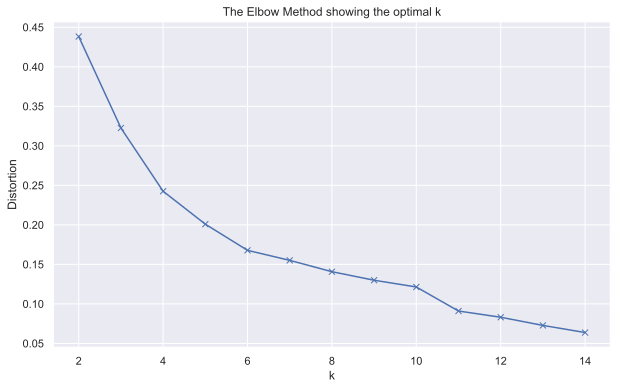

In [228]:
apply_elbow_method(train_df_scaled[features_for_ecology_cl])

**Вывод: оптимальное количество кластеров ecology = 4**

In [229]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=100)
ecology_labels_train = kmeans.fit_predict(train_df_scaled[features_for_ecology_cl])
ecology_labels_test = kmeans.fit_predict(test_df_scaled[features_for_ecology_cl])

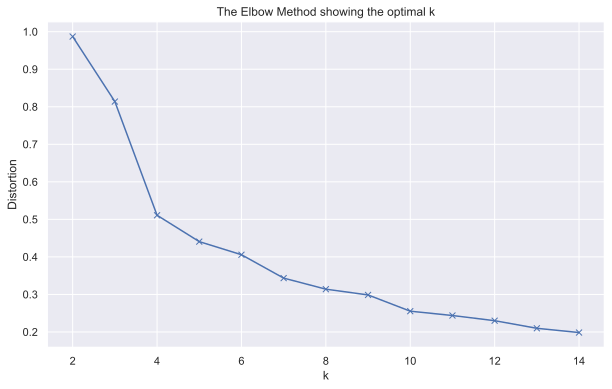

In [230]:
apply_elbow_method(train_df_scaled[features_for_social_cl])

**Вывод: оптимальное количество кластеров social = 4**

In [231]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=100)
social_labels_train = kmeans.fit_predict(train_df_scaled[features_for_social_cl])
social_labels_test = kmeans.fit_predict(test_df_scaled[features_for_social_cl])

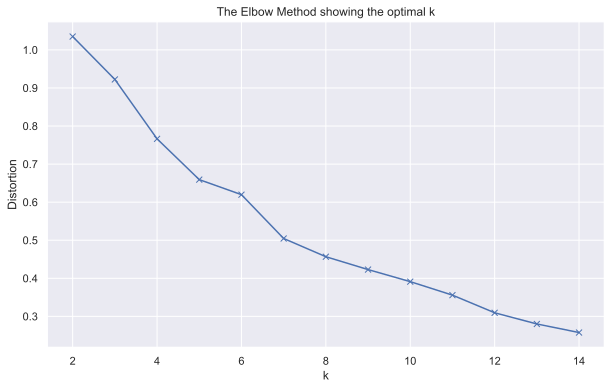

In [232]:
apply_elbow_method(train_df_scaled[features_for_healthcare_cl])

**Вывод: оптимальное количество кластеров healthcare = 5**

In [233]:
kmeans = KMeans(n_clusters=5, random_state=42, max_iter=100)
healthcare_labels_train = kmeans.fit_predict(train_df_scaled[features_for_healthcare_cl])
healthcare_labels_test = kmeans.fit_predict(test_df_scaled[features_for_healthcare_cl])

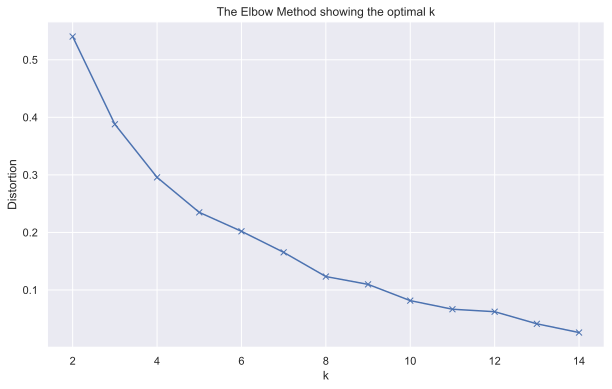

In [234]:
apply_elbow_method(train_df_scaled[features_for_shops_cl])

**Вывод: оптимальное количество кластеров shops = 8**

In [235]:
kmeans = KMeans(n_clusters=8, random_state=42, max_iter=100)
shops_labels_train = kmeans.fit_predict(train_df_scaled[features_for_shops_cl])
shops_labels_test = kmeans.fit_predict(test_df_scaled[features_for_shops_cl])

In [236]:
train_df_ext = pd.concat([train_df_new.reset_index(), 
                          pd.Series(ecology_labels_train), 
                          pd.Series(social_labels_train),
                          pd.Series(healthcare_labels_train),
                          pd.Series(shops_labels_train)], axis=1)
train_df_ext.set_index('Id', inplace=True)

In [237]:
train_df_ext = train_df_ext.rename(columns={0: "ecology_cl", 1: "social_cl", 2: "healthcare_cl", 3: "shops_cl"})

In [238]:
train_df_ext.shape

(10000, 35)

In [239]:
test_df_ext = pd.concat([test_df_new.reset_index(), 
                         pd.Series(ecology_labels_test), 
                         pd.Series(social_labels_test),
                         pd.Series(healthcare_labels_test),
                         pd.Series(shops_labels_test)], axis=1)
test_df_ext.set_index('Id', inplace=True)

In [240]:
test_df_ext = test_df_ext.rename(columns={0: "ecology_cl", 1: "social_cl", 2: "healthcare_cl", 3: "shops_cl"})

In [241]:
test_df_ext.shape

(5000, 34)

**Соберем еще один набор данных для обучения со стандартизованными значениями признаков (scaled)**

In [242]:
train_df_scaled_ext = pd.concat([train_df_scaled.reset_index(), 
                                 pd.Series(ecology_labels_train), 
                                 pd.Series(social_labels_train),
                                 pd.Series(healthcare_labels_train),
                                 pd.Series(shops_labels_train)], axis=1)
train_df_scaled_ext.set_index('Id', inplace=True)

In [243]:
train_df_scaled_ext = train_df_scaled_ext.rename(columns={'0': "ecology_cl", '1': "social_cl", '2': "healthcare_cl", '3': "shops_cl"})

In [244]:
test_df_scaled_ext = pd.concat([test_df_scaled.reset_index(), 
                                pd.Series(ecology_labels_test), 
                                pd.Series(social_labels_test),
                                pd.Series(healthcare_labels_test),
                                pd.Series(shops_labels_test)], axis=1)
test_df_scaled_ext.set_index('Id', inplace=True)

In [245]:
test_df_scaled_ext = test_df_scaled_ext.rename(columns={'0': "ecology_cl", '1': "social_cl", '2': "healthcare_cl", '3': "shops_cl"})

## Замена категориальных признаков на dummies

In [246]:
ecology_clusters_dummies_train = pd.get_dummies(ecology_labels_train, drop_first=True, prefix='ecology_cl')
ecology_clusters_dummies_test = pd.get_dummies(ecology_labels_test, drop_first=True, prefix='ecology_cl')

social_clusters_dummies_train = pd.get_dummies(social_labels_train, drop_first=True, prefix='social_cl')
social_clusters_dummies_test = pd.get_dummies(social_labels_test, drop_first=True, prefix='social_cl')

healthcare_clusters_dummies_train = pd.get_dummies(healthcare_labels_train, drop_first=True, prefix='healthcare_cl')
healthcare_clusters_dummies_test = pd.get_dummies(healthcare_labels_test, drop_first=True, prefix='healthcare_cl')

shops_clusters_dummies_train = pd.get_dummies(shops_labels_train, drop_first=True, prefix='shops_cl')
shops_clusters_dummies_test = pd.get_dummies(shops_labels_test, drop_first=True, prefix='shops_cl')

In [247]:
train_df_ext_dm = pd.concat([train_df_new.reset_index(), 
                             ecology_clusters_dummies_train, 
                             social_clusters_dummies_train,
                             healthcare_clusters_dummies_train,
                             shops_clusters_dummies_train], axis=1)
train_df_ext_dm.set_index('Id', inplace=True)

In [248]:
train_df_ext_dm.shape

(10000, 48)

In [249]:
test_df_ext_dm = pd.concat([test_df_new.reset_index(), 
                            ecology_clusters_dummies_test, 
                            social_clusters_dummies_test,
                            healthcare_clusters_dummies_test,
                            shops_clusters_dummies_test], axis=1)
test_df_ext_dm.set_index('Id', inplace=True)

In [250]:
test_df_ext_dm.shape

(5000, 47)

In [251]:
train_df_scaled_ext_dm = pd.concat([train_df_scaled.reset_index(), 
                                    ecology_clusters_dummies_train, 
                                    social_clusters_dummies_train,
                                    healthcare_clusters_dummies_train,
                                    shops_clusters_dummies_train], axis=1)
train_df_scaled_ext_dm.set_index('Id', inplace=True)

In [252]:
train_df_scaled_ext_dm.shape

(10000, 47)

In [253]:
test_df_scaled_ext_dm = pd.concat([test_df_scaled.reset_index(), 
                                   ecology_clusters_dummies_test, 
                                   social_clusters_dummies_test,
                                   healthcare_clusters_dummies_test,
                                   shops_clusters_dummies_test], axis=1)
test_df_scaled_ext_dm.set_index('Id', inplace=True)

In [254]:
test_df_scaled_ext_dm.shape

(5000, 47)

In [255]:
house_age_dummies_train = pd.get_dummies(train_df_new['HouseAgeGroup'], drop_first=True, prefix='house_age_gr')
house_age_dummies_test = pd.get_dummies(test_df_new['HouseAgeGroup'], drop_first=True, prefix='house_age_gr')

square_dummies_train = pd.get_dummies(train_df_new['SquareGroup'], drop_first=True, prefix='square_gr')
square_dummies_test = pd.get_dummies(test_df_new['SquareGroup'], drop_first=True, prefix='square_gr')

floor_dummies_train = pd.get_dummies(train_df_new['FloorGroup'], drop_first=True, prefix='floor_gr')
floor_dummies_test = pd.get_dummies(test_df_new['FloorGroup'], drop_first=True, prefix='floor_gr')

helthcare_2_dummies_train = pd.get_dummies(train_df_new['Helthcare_2'], drop_first=True, prefix='helthcare_2_gr')
helthcare_2_dummies_test = pd.get_dummies(test_df_new['Helthcare_2'], drop_first=True, prefix='helthcare_2_gr')

In [256]:
train_df_ext_dm_full = train_df_ext_dm.join(house_age_dummies_train)
train_df_ext_dm_full = train_df_ext_dm_full.join(square_dummies_train)
train_df_ext_dm_full = train_df_ext_dm_full.join(floor_dummies_train)
train_df_ext_dm_full = train_df_ext_dm_full.join(helthcare_2_dummies_train)

In [257]:
train_df_ext_dm_full.shape

(10000, 67)

In [258]:
train_df_scaled_ext_dm_full = train_df_scaled_ext_dm.join(house_age_dummies_train)
train_df_scaled_ext_dm_full = train_df_scaled_ext_dm_full.join(square_dummies_train)
train_df_scaled_ext_dm_full = train_df_scaled_ext_dm_full.join(floor_dummies_train)
train_df_scaled_ext_dm_full = train_df_scaled_ext_dm_full.join(helthcare_2_dummies_train)    

In [259]:
train_df_scaled_ext_dm_full.shape

(10000, 66)

In [260]:
test_df_ext_dm_full = test_df_ext_dm.join(house_age_dummies_test)
test_df_ext_dm_full = test_df_ext_dm_full.join(square_dummies_test)
test_df_ext_dm_full = test_df_ext_dm_full.join(floor_dummies_test)
test_df_ext_dm_full = test_df_ext_dm_full.join(helthcare_2_dummies_test)

In [261]:
test_df_ext_dm_full.shape

(5000, 66)

In [262]:
test_df_scaled_ext_dm_full = test_df_scaled_ext_dm.join(house_age_dummies_test)
test_df_scaled_ext_dm_full = test_df_scaled_ext_dm_full.join(square_dummies_test)
test_df_scaled_ext_dm_full = test_df_scaled_ext_dm_full.join(floor_dummies_test)
test_df_scaled_ext_dm_full = test_df_scaled_ext_dm_full.join(helthcare_2_dummies_test)   

In [263]:
test_df_scaled_ext_dm_full.shape

(5000, 66)

In [264]:
train_df_ext_dm_full.drop(['HouseAgeGroup', 'SquareGroup', 'FloorGroup', 'Helthcare_2'], axis=1, inplace=True)
test_df_ext_dm_full.drop(['HouseAgeGroup', 'SquareGroup', 'FloorGroup', 'Helthcare_2'], axis=1, inplace=True)

In [265]:
train_df_scaled_ext_dm_full.drop(['HouseAgeGroup', 'SquareGroup', 'FloorGroup', 'Helthcare_2'], axis=1, inplace=True)
test_df_scaled_ext_dm_full.drop(['HouseAgeGroup', 'SquareGroup', 'FloorGroup', 'Helthcare_2'], axis=1, inplace=True)

## Сохрание промежуточных результатов анализа и трансформации train и test

In [230]:
train_df_ext.to_csv('train_df_ext.csv', encoding='utf-8')
test_df_ext.to_csv('test_df_ext.csv', encoding='utf-8')

In [231]:
train_df_scaled_ext.to_csv('train_df_scaled_ext.csv', encoding='utf-8')
test_df_scaled_ext.to_csv('test_df_scaled_ext.csv', encoding='utf-8')

In [232]:
train_df_ext_dm_full.to_csv('train_df_ext_dm_full.csv', encoding='utf-8')
test_df_ext_dm_full.to_csv('test_df_ext_dm_full.csv', encoding='utf-8')

In [233]:
train_df_scaled_ext_dm_full.to_csv('train_df_scaled_ext_dm_full.csv', encoding='utf-8')
test_df_scaled_ext_dm_full.to_csv('test_df_scaled_ext_dm_full.csv', encoding='utf-8')

## Обучение и подбор моделей ML

In [2]:
train_df_ext = pd.read_csv('train_df_ext.csv', index_col='Id')
test_df_ext = pd.read_csv('test_df_ext.csv', index_col='Id')

In [3]:
train_df_scaled_ext = pd.read_csv('train_df_scaled_ext.csv', index_col='Id')
test_df_scaled_ext = pd.read_csv('test_df_scaled_ext.csv', index_col='Id')

In [4]:
train_df_ext_dm_full = pd.read_csv('train_df_ext_dm_full.csv', index_col='Id')
test_df_ext_dm_full = pd.read_csv('test_df_ext_dm_full.csv', index_col='Id')

In [5]:
train_df_scaled_ext_dm_full = pd.read_csv('train_df_scaled_ext_dm_full.csv', index_col='Id')
test_df_scaled_ext_dm_full = pd.read_csv('test_df_scaled_ext_dm_full.csv', index_col='Id')

In [6]:
y = train_df_ext[['Price']]

train_df_ext.drop(['Price'], axis=1, inplace=True)
train_df_ext_dm_full.drop(['Price'], axis=1, inplace=True)

### LinearRegression

In [141]:
lr = LinearRegression()

In [142]:
def model_eval(model, X_tr, y_tr):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_score = cross_val_score(model, X_tr, y_tr, scoring='r2', cv=kf)
    print('R2: {:.5f}'.format(cv_score.mean()))

In [143]:
base_features = [
 #'Price',
 #'DistrictId', 
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2' 
]

In [144]:
# Базовая модель
X = train_df_new[base_features]
model_eval(lr, X, y)

R2: 0.47576


In [13]:
all_ext_features = train_df_ext.columns.to_list()
all_ext_features

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseAgeGroup',
 'SquareGroup',
 'FloorGroup',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price1mByDistrict',
 'IsFirstFloor',
 'IsLastFloor',
 'SquareOutliers',
 'DistrictSize',
 'PriceOneRoomByDistrict',
 'Price1mBySquareGroup',
 'Price1mByFloorGroup',
 'FloorOutliers',
 'Price1mByAgeGroup',
 'ecology_cl',
 'social_cl',
 'healthcare_cl',
 'shops_cl']

In [14]:
X = train_df_ext[all_ext_features]

model_eval(lr, X, y)

R2: 0.67816


In [15]:
X = train_df_scaled_ext[all_ext_features]

model_eval(lr, X, y)

R2: 0.67816


In [16]:
all_ext_dm_features = train_df_ext_dm_full.columns.to_list()
all_ext_dm_features

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Shops_1',
 'Shops_2',
 'Price1mByDistrict',
 'IsFirstFloor',
 'IsLastFloor',
 'SquareOutliers',
 'DistrictSize',
 'PriceOneRoomByDistrict',
 'Price1mBySquareGroup',
 'Price1mByFloorGroup',
 'FloorOutliers',
 'Price1mByAgeGroup',
 'ecology_cl_1',
 'ecology_cl_2',
 'ecology_cl_3',
 'social_cl_1',
 'social_cl_2',
 'social_cl_3',
 'healthcare_cl_1',
 'healthcare_cl_2',
 'healthcare_cl_3',
 'healthcare_cl_4',
 'shops_cl_1',
 'shops_cl_2',
 'shops_cl_3',
 'shops_cl_4',
 'shops_cl_5',
 'shops_cl_6',
 'shops_cl_7',
 'house_age_gr_1',
 'house_age_gr_2',
 'house_age_gr_3',
 'square_gr_1',
 'square_gr_2',
 'square_gr_3',
 'square_gr_4',
 'square_gr_5',
 'square_gr_6',
 'floor_gr_1',
 'floor_gr_2',
 'floor_gr_3',
 'floor_gr_4',
 'helthcare_2_gr_1',
 'helthcare_2_gr_2',
 'helthcare_2_gr_3',
 'helthcare_2_gr_4

In [17]:
X = train_df_ext_dm_full[all_ext_dm_features]

model_eval(lr, X, y)

R2: 0.68525


In [18]:
X = train_df_scaled_ext_dm_full[all_ext_dm_features]

model_eval(lr, X, y)

R2: 0.68525


**Вывод: набор данных train_df_scaled_ext_dm_full показал лучшие результаты среди прочих, поэтому дальше будем использовать только его для тюнинга модели**

**Подберем оптимальный набор признаков**

In [19]:
X = train_df_scaled_ext_dm_full[all_ext_dm_features]
lr.fit(X, y)

LinearRegression()

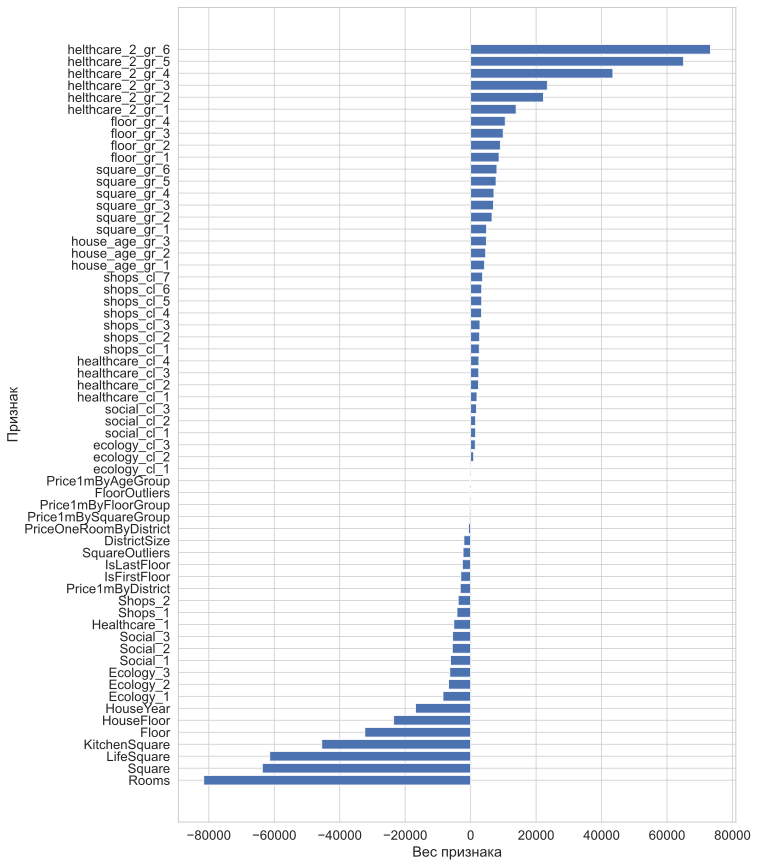

In [20]:
plt.rcParams['figure.figsize'] = (10, 15)
plt.barh(all_ext_dm_features, lr.coef_.flatten()[lr.coef_.flatten().argsort()])
plt.xlabel("Вес признака")
plt.ylabel("Признак")
plt.show()

In [21]:
optimal_lr_features = [
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Shops_1',
 'Shops_2',
 'Price1mByDistrict',
 'IsFirstFloor',
 'IsLastFloor',
 'SquareOutliers',
 'DistrictSize',
 #'PriceOneRoomByDistrict',
 #'Price1mBySquareGroup',
 #'Price1mByFloorGroup',
 #'FloorOutliers',
 #'Price1mByAgeGroup',
 'ecology_cl_1',
 'ecology_cl_2',
 'ecology_cl_3',
 'social_cl_1',
 'social_cl_2',
 'social_cl_3',
 'healthcare_cl_1',
 'healthcare_cl_2',
 'healthcare_cl_3',
 'healthcare_cl_4',
 'shops_cl_1',
 'shops_cl_2',
 'shops_cl_3',
 'shops_cl_4',
 'shops_cl_5',
 'shops_cl_6',
 'shops_cl_7',
 'house_age_gr_1',
 'house_age_gr_2',
 'house_age_gr_3',
 'square_gr_1',
 'square_gr_2',
 'square_gr_3',
 'square_gr_4',
 'square_gr_5',
 'square_gr_6',
 'floor_gr_1',
 'floor_gr_2',
 'floor_gr_3',
 'floor_gr_4',
 'helthcare_2_gr_1',
 'helthcare_2_gr_2',
 'helthcare_2_gr_3',
 'helthcare_2_gr_4',
 'helthcare_2_gr_5',
 'helthcare_2_gr_6'
]

In [22]:
X = train_df_scaled_ext_dm_full[optimal_lr_features]

model_eval(lr, X, y)

R2: 0.68434


**Вывод: лучше всего использовать все признаки, т.к. значение метрики r2 снижается, если какие-то признаки убирать**

In [23]:
X = train_df_scaled_ext_dm_full[all_ext_dm_features]
lr.fit(X, y)

LinearRegression()

### Random Forest

In [7]:
forest = RandomForestRegressor(max_depth=16, 
                               max_features=10, 
                               n_estimators=100,
                               random_state=42)

In [35]:
X = train_df_ext[all_ext_features]

model_eval(forest, X, y)

R2: 0.75734


In [36]:
X = train_df_scaled_ext[all_ext_features]

model_eval(forest, X, y)

R2: 0.75763


In [37]:
X = train_df_ext_dm_full[all_ext_dm_features]

model_eval(forest, X, y)

R2: 0.75641


In [38]:
X = train_df_scaled_ext_dm_full[all_ext_dm_features]

model_eval(forest, X, y)

R2: 0.75651


**Вывод: набор данных train_df_scaled_ext показал наилучшие результаты, поэтому дальше будем использовать его для обучения и оптимизации**

**Важность признаков**

In [39]:
X = train_df_scaled_ext[all_ext_features]
forest.fit(X, y)
importances = forest.feature_importances_
feat_importances = pd.Series(importances, index=X.columns.tolist())
feat_importances.sort_values(ascending=True, inplace=True)

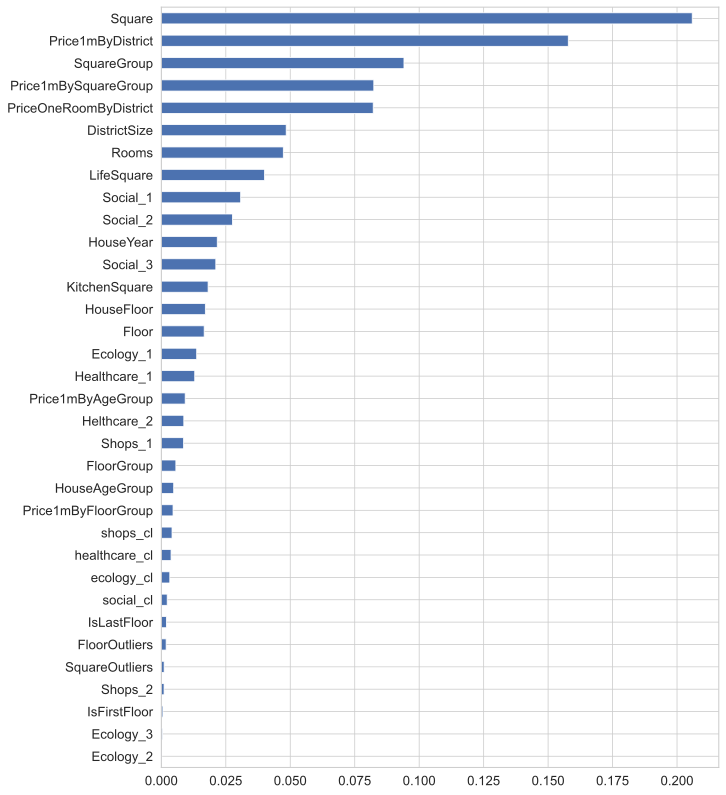

In [40]:
feat_importances.plot(kind='barh', figsize=(10, 14));

In [9]:
optimal_ext_features = [
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseAgeGroup',
 'SquareGroup',
 'FloorGroup',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 #'Ecology_2',
 #'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price1mByDistrict',
 'IsFirstFloor',
 'IsLastFloor',
 'SquareOutliers',
 'DistrictSize',
 #'PriceOneRoomByDistrict',
 'Price1mBySquareGroup',
 'Price1mByFloorGroup',
 'FloorOutliers',
 'Price1mByAgeGroup',
 'ecology_cl',
 'social_cl',
 'healthcare_cl',
 'shops_cl'
]

In [44]:
X = train_df_scaled_ext[optimal_ext_features]

model_eval(forest, X, y)

R2: 0.75951


**Вывод: если отбросить незначимые признаки Ecology_2, Ecology_3, то значение метрики становится больше, поэтому дальше будем использвоать набор признаков optimal_ext_features**

**Подбор оптимальных параметров**

In [46]:
X = train_df_scaled_ext[optimal_ext_features]

params = {
    'n_estimators': [100],
    'max_depth': [14, 15, 16],
    'max_features': [11, 12, 13]
}

forest_grid = GridSearchCV(forest, params, scoring='r2', 
                  cv=KFold(n_splits=6, random_state=42, shuffle=True), 
                  n_jobs=-1)
forest_grid.fit(X, y)
print(forest_grid.best_params_)
print('R2: {:.5f}'.format(forest_grid.best_score_))

{'max_depth': 15, 'max_features': 11, 'n_estimators': 100}
R2: 0.75847


{'max_depth': 15, 'max_features': 11, 'n_estimators': 100} R2: 0.75847

In [13]:
X = train_df_scaled_ext[optimal_ext_features]

params = {
    'n_estimators': [5000],
    'max_depth': [15],
    'max_features': [9]
}

forest_grid = GridSearchCV(forest, params, scoring='r2', 
                  cv=KFold(n_splits=10, random_state=42, shuffle=True), 
                  n_jobs=-1)
forest_grid.fit(X, y)
print(forest_grid.best_params_)
print('R2: {:.5f}'.format(forest_grid.best_score_))

{'max_depth': 11, 'max_features': 11, 'n_estimators': 5000}
R2: 0.76077


{'max_depth': 15, 'max_features': 11, 'n_estimators': 1000} R2: 0.76124

{'max_depth': 15, 'max_features': 11, 'n_estimators': 2000} R2: 0.76134

{'max_depth': 13, 'max_features': 11, 'n_estimators': 1000} R2: 0.76256

{'max_depth': 13, 'max_features': 11, 'n_estimators': 3000} R2: 0.76281

{'max_depth': 13, 'max_features': 11, 'n_estimators': 5000} R2: 0.76269

### GradientBoostingRegressor

In [52]:
gb_model = GradientBoostingRegressor(
    n_estimators=90,
    n_iter_no_change=10,
    max_depth=6,
    max_features=9,
    random_state=42)

In [53]:
X = train_df_ext[all_ext_features]

model_eval(gb_model, X, y)

R2: 0.76539


In [54]:
X = train_df_scaled_ext[all_ext_features]

model_eval(gb_model, X, y)

R2: 0.76665


In [55]:
X = train_df_ext_dm_full[all_ext_dm_features]

model_eval(gb_model, X, y)

R2: 0.76157


In [56]:
X = train_df_scaled_ext_dm_full[all_ext_dm_features]

model_eval(gb_model, X, y)

R2: 0.75964


**Вывод: наилучшие показатели у набора данных train_df_scaled_ext, поэтому дальше будем использовать только его.**

**Важность признаков**

In [58]:
X = train_df_scaled_ext[all_ext_features]

gb_model.fit(X, y)
importances = gb_model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns.tolist())
feat_importances.sort_values(ascending=True, inplace=True)

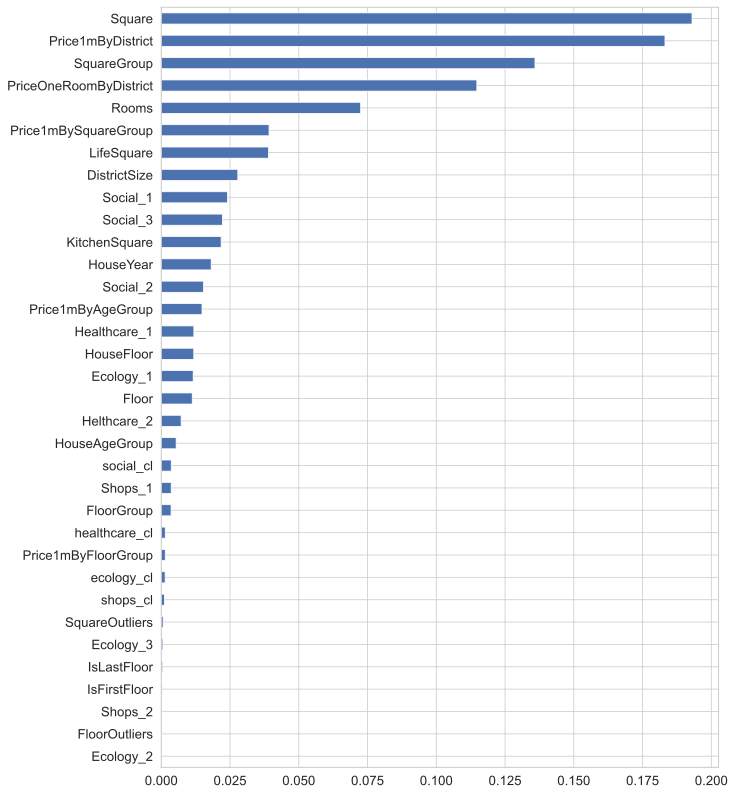

In [59]:
feat_importances.plot(kind='barh', figsize=(10, 14));

**Подбор оптимальных параметров**

In [73]:
optimal_gbr_features = [
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseAgeGroup',
 'SquareGroup',
 'FloorGroup',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 #'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price1mByDistrict',
 'IsFirstFloor',
 'IsLastFloor',
 #'SquareOutliers',
 #'DistrictSize',
 'PriceOneRoomByDistrict',
 'Price1mBySquareGroup',
 'Price1mByFloorGroup',
 'FloorOutliers',
 'Price1mByAgeGroup',
 'ecology_cl',
 'social_cl',
 'healthcare_cl',
 'shops_cl'
]

In [74]:
X = train_df_scaled_ext[optimal_gbr_features]

model_eval(gb_model, X, y)

R2: 0.76020


**Удаление незначимых признаков приводит к ухудшению метрики r2, поэтому дальше будем использовать полный набор признаков**

**Подбор оптимальных параметров**

In [71]:
X = train_df_scaled_ext[all_ext_features]

params = {
    'n_estimators': [80, 90, 100],
    'n_iter_no_change': [10],
    'max_depth': [5, 6, 7],
    'max_features': [8, 9, 10]
}

grad_grid = GridSearchCV(gb_model, params, scoring='r2', 
                  cv=KFold(n_splits=10, random_state=42, shuffle=True), 
                  n_jobs=-1)
grad_grid.fit(X, y)
print(grad_grid.best_params_)
print('R2: {:.5f}'.format(grad_grid.best_score_))

{'max_depth': 6, 'max_features': 9, 'n_estimators': 100, 'n_iter_no_change': 10}
R2: 0.76681


{'max_depth': 6, 'max_features': 9, 'n_estimators': 100, 'n_iter_no_change': 10} R2: 0.76115 (optimal_ext_features)

{'max_depth': 6, 'max_features': 9, 'n_estimators': 90, 'n_iter_no_change': 10} R2: 0.76162 (optimal_ext_features)

{'max_depth': 6, 'max_features': 9, 'n_estimators': 90, 'n_iter_no_change': 10} R2: 0.76296 (#'Ecology_2', #'SquareOutliers', #'DistrictSize')

{'max_depth': 6, 'max_features': 9, 'n_estimators': 100, 'n_iter_no_change': 10}
R2: 0.76681

### CatBoostRegressor

In [84]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
cbr = CatBoostRegressor()

In [78]:
cbr_features = ['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseAgeGroup',
 'SquareGroup',
 'FloorGroup',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 #'Price',
 'Price1mByDistrict',
 'IsFirstFloor',
 'IsLastFloor',
 'SquareOutliers',
 'DistrictSize',
 'PriceOneRoomByDistrict',
 'Price1mBySquareGroup',
 'Price1mByFloorGroup',
 'FloorOutliers',
 'Price1mByAgeGroup']

In [79]:
cbr_cat_features = [
 'HouseAgeGroup',
 'SquareGroup',
 'FloorGroup', 
 'Helthcare_2', 
 'IsFirstFloor',
 'IsLastFloor',
 'SquareOutliers', 
 'FloorOutliers', 
 'Ecology_2',
 'Ecology_3',
 'Shops_2'
]

In [80]:
X = train_df_new[cbr_features]
y = train_df_new[['Price']]

In [82]:
grid = {'learning_rate': [0.01, 0.03, 0.1],
        'depth': [7, 8, 9],
        'reg_lambda': [1, 3, 5],
        'silent': [True]}

In [85]:
cbr_grid = GridSearchCV(estimator=cbr, 
                        param_grid=grid, 
                        scoring='r2', 
                        cv=KFold(n_splits=10, random_state=42, shuffle=True), 
                        n_jobs=-1)
cbr_grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x00000268E962CA90>,
             n_jobs=-1,
             param_grid={'depth': [7, 8, 9], 'learning_rate': [0.01, 0.03, 0.1],
                         'reg_lambda': [1, 3, 5], 'silent': [True]},
             scoring='r2')

In [86]:
print(cbr_grid.best_params_)
print('R2: {:.5f}'.format(cbr_grid.best_score_))

{'depth': 7, 'learning_rate': 0.03, 'reg_lambda': 3, 'silent': True}
R2: 0.77088


In [87]:
grid = {'learning_rate': [0.03],
        'depth': [6, 7, 8],
        'reg_lambda': [3],
        'silent': [True]}

In [88]:
cbr_grid = GridSearchCV(estimator=cbr, 
                        param_grid=grid, 
                        scoring='r2', 
                        cv=KFold(n_splits=10, random_state=42, shuffle=True), 
                        n_jobs=-1)
cbr_grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x00000268E962CA90>,
             n_jobs=-1,
             param_grid={'depth': [6, 7, 8], 'learning_rate': [0.03],
                         'reg_lambda': [3], 'silent': [True]},
             scoring='r2')

In [90]:
print(cbr_grid.best_params_)
print('R2: {:.5f}'.format(cbr_grid.best_score_))

{'depth': 7, 'learning_rate': 0.03, 'reg_lambda': 3, 'silent': True}
R2: 0.77088


**Обучим модель с лучшими параметрами для подготовки прогноза для Kaggle**

In [91]:
cbr_best = CatBoostRegressor(depth=7, reg_lambda=3, learning_rate=0.03, silent=True)
cbr_best.fit(X, y, verbose=False, cat_features=cbr_cat_features)

## Прогнозирование на тестовом датасете

In [92]:
preds = pd.DataFrame()

**Lenear Regression**

In [95]:
X_test = test_df_scaled_ext_dm_full[all_ext_dm_features]
y_pred = lr.predict(X_test)

In [96]:
preds['Id'] = X_test.index
preds['lr_price'] = y_pred

In [97]:
preds.head()

,Id,lr_price
0,725,"129,910.54"
1,15856,"212,091.41"
2,5480,"418,025.10"
3,15664,"271,550.32"
4,14275,"69,536.99"


In [98]:
preds.shape

(5000, 2)

**Random Forest**

In [99]:
X_test = test_df_scaled_ext[optimal_ext_features]
forest_best = forest_grid.best_estimator_
y_pred = forest_best.predict(X_test)

In [100]:
preds['forest_price'] = y_pred

**GradientBoostingRegressor**

In [101]:
X_test = test_df_scaled_ext[all_ext_features]
grad_best = grad_grid.best_estimator_
y_pred = grad_best.predict(X_test)

In [102]:
preds['gbr_price'] = y_pred

**CatBoostRegressor**

In [103]:
X_test = test_df_new[cbr_features]
y_pred = cbr_best.predict(X_test)

In [104]:
preds['cbr_price'] = y_pred

## Сохранение итогового результата

In [124]:
preds.index

RangeIndex(start=0, stop=5000, step=1)

In [110]:
preds['mean_price'] = (preds['lr_price'] + preds['forest_price'] + preds['gbr_price'] + preds['cbr_price']) / 4

In [111]:
preds['mean_price_wo_lr'] = (preds['forest_price'] + preds['gbr_price'] + preds['cbr_price']) / 3

In [125]:
preds.set_index('Id', inplace=True)

In [126]:
preds.head(10)

,lr_price,forest_price,gbr_price,cbr_price,mean_price,mean_price_wo_lr
Id,,,,,,
725,"129,910.54","157,873.44","147,667.96","151,037.34","146,622.32","152,192.91"
15856,"212,091.41","219,447.46","221,658.99","218,711.43","217,977.32","219,939.29"
5480,"418,025.10","269,822.51","262,158.98","259,691.37","302,424.49","263,890.96"
15664,"271,550.32","308,769.59","300,022.56","337,332.52","304,418.75","315,374.89"
14275,"69,536.99","137,857.50","125,301.13","136,578.02","117,318.41","133,245.55"
7633,"229,224.67","212,140.69","222,791.10","215,324.36","219,870.21","216,752.05"
13329,"141,232.47","166,662.20","160,198.26","159,540.10","156,908.26","162,133.52"
5502,"231,077.67","223,589.90","222,063.49","229,942.02","226,668.27","225,198.47"
4220,"283,054.00","297,033.74","281,120.82","290,480.16","287,922.18","289,544.91"


In [132]:
preds[['mean_price']].to_csv('mean_price.csv')

**Вывод: использование сразу всех моделей и усреднение полученных предсказаний не дает хорошего результата (r2 = 0.74721, вторая половина рейтинга). Поэтому дальше посмотрим на результаты каждой отдельной модели с наилучшими показателями r2 при тестировании**

In [134]:
preds[['mean_price_wo_lr']].to_csv('mean_price_wo_lr.csv')

**Вывод: r2 на тествых данных без учета результатов линейной регрессии = 0.75872, что значительно лучше**

**GradientBoostingRegressor**

In [137]:
preds[['gbr_price']].to_csv('gbr_price.csv')

**Вывод: r2 на тествых данных = 0.75483**

**Random Forest**

In [138]:
preds[['forest_price']].to_csv('forest_price.csv')

**Вывод: r2 на тествых данных = 0.74794**

**CatBoostRegressor**

In [133]:
preds[['cbr_price']].to_csv('cbr_price.csv')

**Вывод: r2 на тестовых данных = 0.762, 37-е место в рейтинге из 487**

## Итоговые выводы
1. Использование ансамбля из 3-х моделей позволило улучшить результаты предсказаний цены относительно предсказаний, сделанных с использованием только какой-то одной из моделей. 
2. Однако, модель CatBoostRegressor показала результат даже лучше, чем среднее значение на основе предсказаний 3-х моделей (0.762, 37-е место в рейтинге из 487), поэтому именно ее можно рекомендовать для создания промышленной модели данных и дальнейшего использования.